In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import yfinance as yf
import numpy as np
import pandas as pd
import pyfolio as pf
import scipy.optimize as sco

plt.style.use('seaborn')
sns.set_palette('cubehelix')
# plt.style.use('seaborn-colorblind') #alternative
plt.rcParams['figure.figsize'] = [5, 3.5]
plt.rcParams['figure.dpi'] = 150
warnings.simplefilter(action='ignore', category=FutureWarning)

C:\Users\LuisH\anaconda3\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


# Homework 3

## Import Data

In [2]:
N_PORTFOLIOS = 10 ** 5 
N_DAYS = 252
RISKY_ASSETS = ['AAPL', 'IBM', 'MSFT']
START_DATE = '2018-01-01'
END_DATE = '2018-12-31'

n_assets = len(RISKY_ASSETS)

prices_df = yf.download(RISKY_ASSETS, start=START_DATE, 
                        end=END_DATE, adjusted=True)
print(f'Downloaded {prices_df.shape[0]} rows of data.')

[*********************100%***********************]  3 of 3 completed
Downloaded 250 rows of data.


## Process Data

In [3]:
returns_df = prices_df['Adj Close'].pct_change().dropna()

avg_returns = returns_df.mean() * N_DAYS
cov_mat = returns_df.cov() * N_DAYS

In [4]:
np.random.seed(42)
weights = np.random.random(size=(N_PORTFOLIOS, n_assets))

weights /= np.sum(weights, axis=1)[:,np.newaxis]

In [5]:
a = np.random.random(size=(N_PORTFOLIOS, n_assets))

In [6]:
a / np.sum(a, axis=1)[:,np.newaxis]

array([[0.40218488, 0.24457949, 0.35323563],
       [0.28399523, 0.53053658, 0.18546818],
       [0.41088767, 0.03102307, 0.55808926],
       ...,
       [0.01841204, 0.37447098, 0.60711698],
       [0.42024789, 0.33860282, 0.24114929],
       [0.30657228, 0.41142684, 0.28200088]])

In [7]:
portf_rtns = np.dot(weights,avg_returns)

portf_vol = []
for i in range(0, len(weights)): 
    portf_vol.append(np.sqrt(np.dot(weights[i].T, 
                                      np.dot(cov_mat, weights[i]))))
portf_vol = np.array(portf_vol) 
portf_sharpe_ratio = portf_rtns / portf_vol 

In [8]:
portf_results_df = pd.DataFrame({'returns': portf_rtns, 
                                 'volatility': portf_vol, 
                                 'sharpe_ratio': portf_sharpe_ratio})

## Create Efficient Frontier

In [9]:
N_POINTS = 100 
portf_vol_ef = []
indices_to_skip = []
portf_rtns_ef = np.linspace(portf_results_df.returns.min(), 
                            portf_results_df.returns.max(), 
                            N_POINTS)

portf_rtns_ef = np.round(portf_rtns_ef, 2)
portf_rtns = np.round(portf_rtns, 2)

for point_index in range(N_POINTS): 
    if portf_rtns_ef[point_index] not in portf_rtns:
        indices_to_skip.append(point_index)
        continue 
    matched_ind = np.where(portf_rtns == portf_rtns_ef[point_index])
    portf_vol_ef.append(np.min(portf_vol[matched_ind]))

portf_rtns_ef = np.delete(portf_rtns_ef, indices_to_skip)

## Plot Efficient Frontier

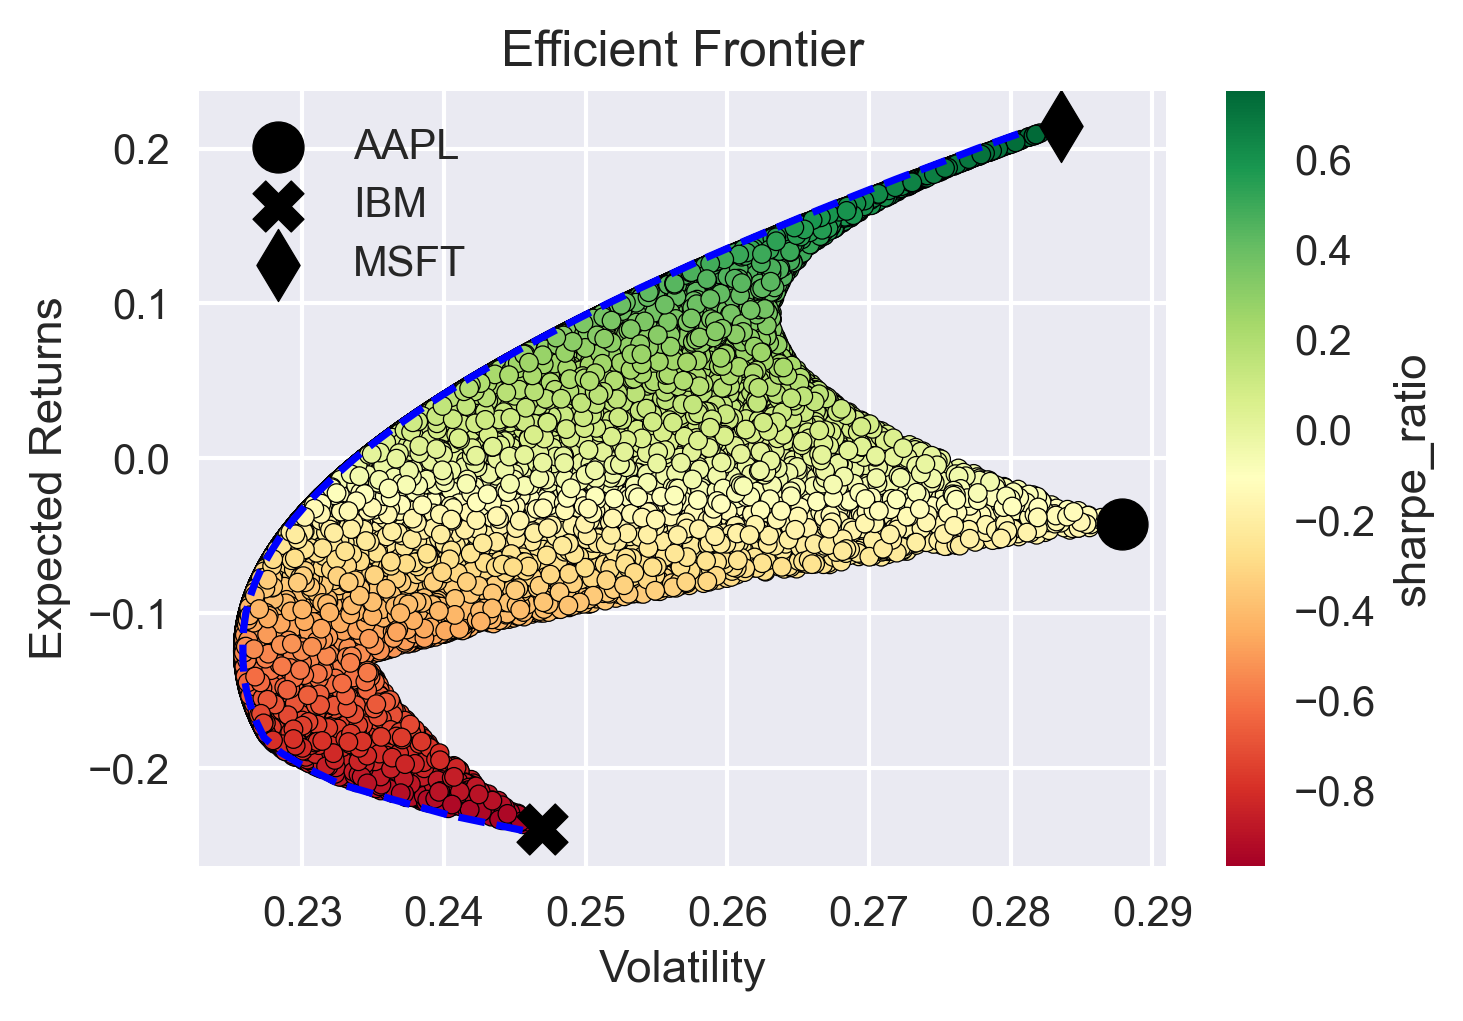

In [10]:
MARKS = ['o', 'X', 'd']

fig, ax = plt.subplots()
portf_results_df.plot(kind='scatter', x='volatility', 
                      y='returns', c='sharpe_ratio',
                      cmap='RdYlGn', edgecolors='black', 
                      ax=ax)
ax.set(xlabel='Volatility', 
       ylabel='Expected Returns', 
       title='Efficient Frontier')
ax.plot(portf_vol_ef, portf_rtns_ef, 'b--')
for asset_index in range(n_assets):
    ax.scatter(x=np.sqrt(cov_mat.iloc[asset_index, asset_index]), 
                y=avg_returns[asset_index], 
                marker=MARKS[asset_index], 
                s=150, 
                color='black',
                label=RISKY_ASSETS[asset_index])
ax.legend()

plt.tight_layout()
plt.show()

## Determine best portfolio weights

In [11]:
max_sharpe_ind = np.argmax(portf_results_df.sharpe_ratio)
max_sharpe_portf = portf_results_df.loc[max_sharpe_ind]
min_vol_ind = np.argmin(portf_results_df.volatility)
min_vol_portf = portf_results_df.loc[min_vol_ind]

In [12]:
print('Maximum Sharpe Ratio portfolio ----')
print('Performance')
for index, value in max_sharpe_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)
print('\nWeights')
for x, y in zip(RISKY_ASSETS, weights[np.argmax(portf_results_df.sharpe_ratio)]):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Maximum Sharpe Ratio portfolio ----
Performance
returns: 21.28% volatility: 28.30% sharpe_ratio: 75.20% 
Weights
AAPL: 0.19% IBM: 0.29% MSFT: 99.52% 

In [13]:
print('Minimum Volatility portfolio ----')
print('Performance')
for index, value in min_vol_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)
print('\nWeights')
for x, y in zip(RISKY_ASSETS, weights[np.argmin(portf_results_df.volatility)]):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Minimum Volatility portfolio ----
Performance
returns: -12.38% volatility: 22.58% sharpe_ratio: -54.84% 
Weights
AAPL: 28.08% IBM: 58.69% MSFT: 13.22% 

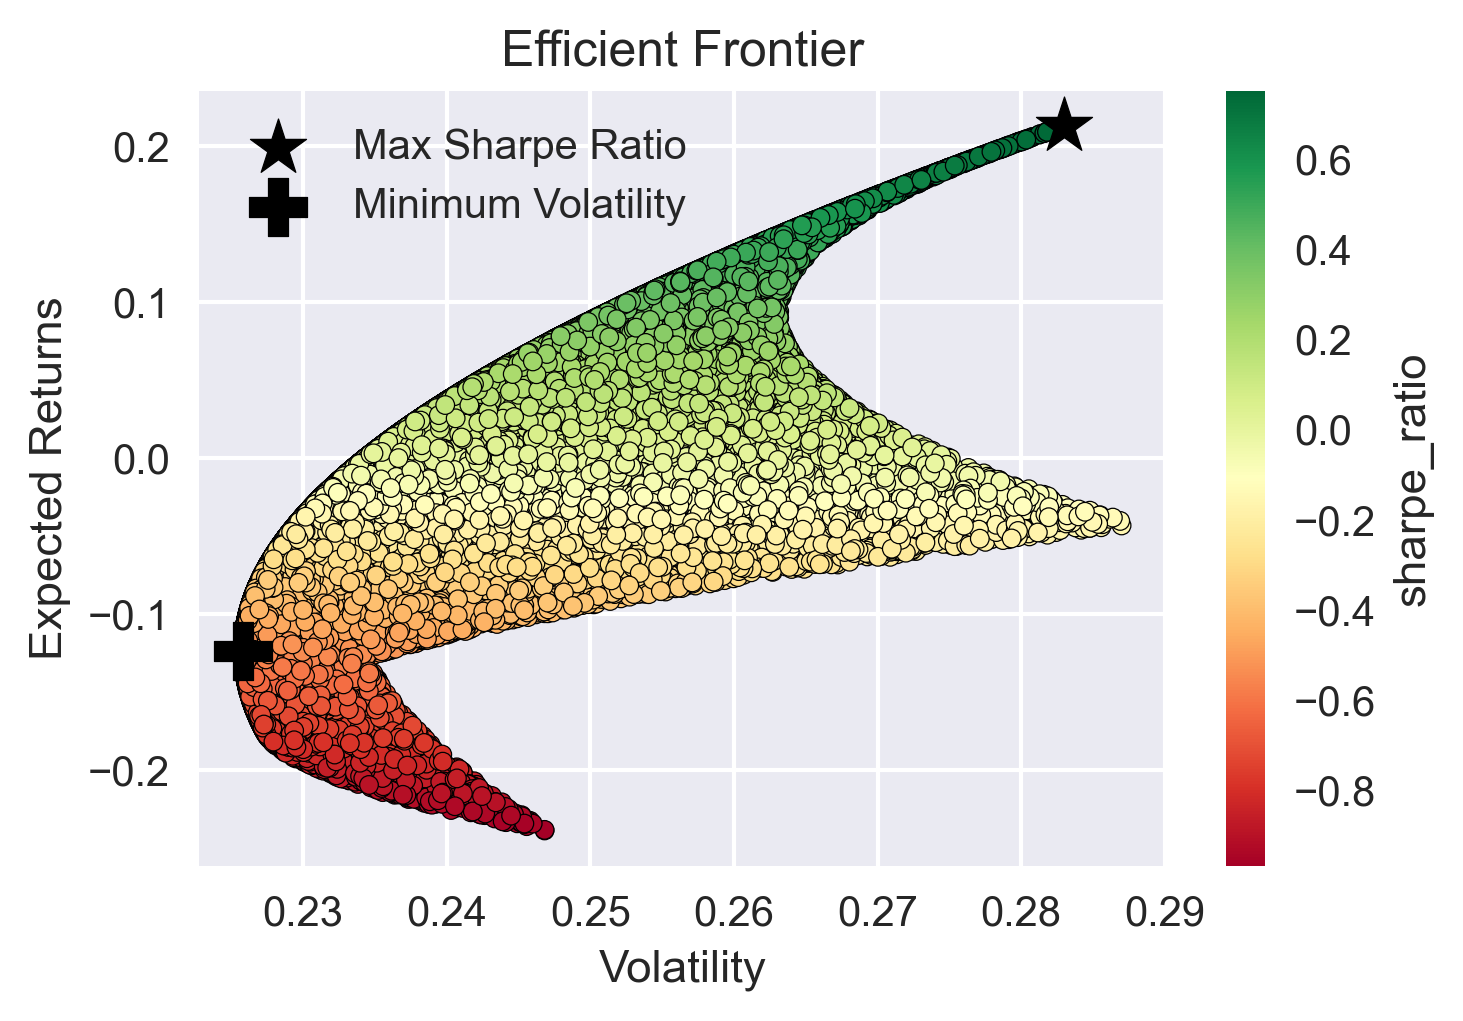

In [14]:
fig, ax = plt.subplots()
portf_results_df.plot(kind='scatter', x='volatility', 
                      y='returns', c='sharpe_ratio',
                      cmap='RdYlGn', edgecolors='black', 
                      ax=ax)
ax.scatter(x=max_sharpe_portf.volatility, 
           y=max_sharpe_portf.returns, 
           c='black', marker='*', 
           s=200, label='Max Sharpe Ratio')
ax.scatter(x=min_vol_portf.volatility, 
           y=min_vol_portf.returns, 
           c='black', marker='P', 
           s=200, label='Minimum Volatility')
ax.set(xlabel='Volatility', ylabel='Expected Returns', 
       title='Efficient Frontier')
ax.legend()

plt.tight_layout()
plt.show()

## Alternative

In [15]:
def get_portf_rtn(w,ave_rtns): 
    return np.sum(ave_rtns * w)

def get_portf_vol(w, avg_rtns, cov_mat): 
    return np.sqrt(np.dot(w.T, np.dot(cov_mat, w)))

In [16]:
def get_efficient_frontier(avg_rtns, cov_mat, rtns_range): 

    efficient_portfolios = []

    n_assets = len(avg_returns) 
    args = (avg_returns, cov_mat)
    bounds = tuple((0,1) for assets in range(n_assets)) 
    initial_guess = n_assets * [1. / n_assets, ] # length: 4 assets with 0.25 

    for ret in rtns_range: 
        constraints = ({'type': 'eq', 
                       'fun': lambda x: get_portf_rtn(x, avg_rtns) - ret}, 
                      {'type': 'eq', 
                       'fun': lambda x: np.sum(x) - 1})
        efficient_portfolio = sco.minimize(get_portf_vol, initial_guess, 
                                           args = args, method = 'SLSQP', 
                                           constraints = constraints,
                                           bounds = bounds)
        efficient_portfolios.append(efficient_portfolio)
    
    return efficient_portfolios

In [17]:
rtns_range = np.linspace(-0.22, 0.25, 200)

In [18]:
efficient_portfolios = get_efficient_frontier(avg_returns, 
                                              cov_mat, 
                                              rtns_range)

In [19]:
vols_range = [x['fun'] for x in efficient_portfolios]

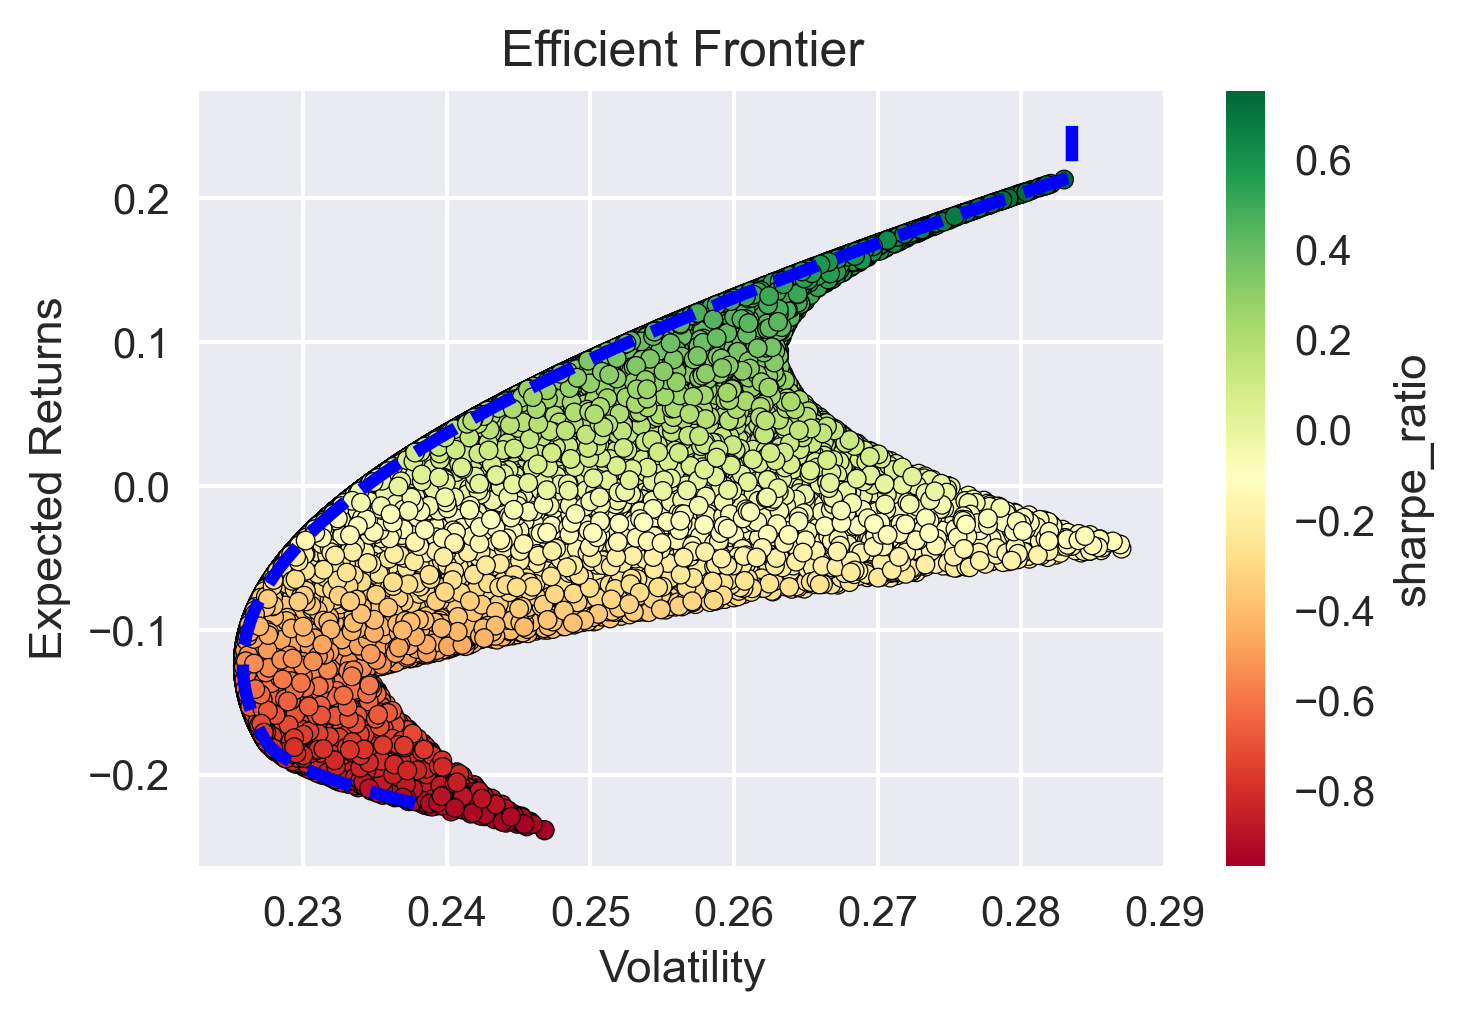

In [20]:
fig, ax = plt.subplots()
portf_results_df.plot(kind='scatter', x='volatility', 
                      y='returns', c='sharpe_ratio',
                      cmap='RdYlGn', edgecolors='black', 
                      ax=ax)
ax.plot(vols_range, rtns_range, 'b--', linewidth=3)
ax.set(xlabel='Volatility', 
       ylabel='Expected Returns', 
       title='Efficient Frontier')

plt.tight_layout()
plt.show()

In [21]:
min_vol_ind = np.argmin(vols_range) 
min_vol_portf_rtn = rtns_range[min_vol_ind]
min_vol_portf_vol = efficient_portfolios[min_vol_ind]['fun']

min_vol_portf = {'Return': min_vol_portf_rtn,
                 'Volatility': min_vol_portf_vol, 
                 'Sharpe Ratio': (min_vol_portf_rtn / 
                                  min_vol_portf_vol)}

min_vol_portf

{'Return': -0.12316582914572866,
 'Volatility': 0.22580434772145924,
 'Sharpe Ratio': -0.5454537540510945}

In [22]:
print('Minimum Volatility portfolio ----')
print('Performance')

for index, value in min_vol_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)

print('\nWeights')
for x, y in zip(RISKY_ASSETS, efficient_portfolios[min_vol_ind]['x']):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Minimum Volatility portfolio ----
Performance
Return: -12.32% Volatility: 22.58% Sharpe Ratio: -54.55% 
Weights
AAPL: 27.90% IBM: 58.65% MSFT: 13.45% 

In [23]:
def neg_sharpe_ratio(w, avg_rtns, cov_mat, rf_rate): 
    portf_returns = np.sum(avg_rtns * w) 
    portf_volatility = np.sqrt(np.dot(w.T, np.dot(cov_mat, w)))
    portf_sharpe_ratio = (portf_returns - rf_rate) / portf_volatility 
    return -portf_sharpe_ratio 

In [24]:
n_assets = len(avg_returns) 
RF_RATE = 0 

args = (avg_returns, cov_mat, RF_RATE)
constraints = ({'type': 'eq', 
                'fun': lambda x: np.sum(x)-1})
bounds = tuple((0,1) for asset in range(n_assets)) 
initial_guess = n_assets * [1. / n_assets]

max_sharpe_portf = sco.minimize(neg_sharpe_ratio, 
                                x0=initial_guess, 
                                args=args, 
                                method='SLSQP', 
                                bounds=bounds, 
                                constraints=constraints)

In [25]:
max_sharpe_portf_w = max_sharpe_portf['x']
max_sharpe_portf = {'Return': get_portf_rtn(max_sharpe_portf_w, 
                                            avg_returns),
                    'Volatility': get_portf_vol(max_sharpe_portf_w, 
                                                avg_returns, 
                                                cov_mat),
                    'Sharpe Ratio': -max_sharpe_portf['fun']}
max_sharpe_portf

{'Return': 0.21458107039179838,
 'Volatility': 0.28353824669434285,
 'Sharpe Ratio': 0.7567976204039908}

In [26]:
print('Maximum Sharpe Ratio portfolio ----')
print('Performance')

for index, value in max_sharpe_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)

print('\nWeights')
for x, y in zip(RISKY_ASSETS, max_sharpe_portf_w):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Maximum Sharpe Ratio portfolio ----
Performance
Return: 21.46% Volatility: 28.35% Sharpe Ratio: 75.68% 
Weights
AAPL: 0.00% IBM: 0.00% MSFT: 100.00% 

# Homework 4

#### I will use the weights from the alternative method

## Monte-Carlo Simulation of Maximum Sharpe Ratio Portfolio

In [27]:
df = yf.download(RISKY_ASSETS, start=START_DATE, 
                 end=END_DATE, adjusted=True)
print(f'Downloaded {df.shape[0]} rows of data.')

[*********************100%***********************]  3 of 3 completed
Downloaded 250 rows of data.


In [28]:
adj_close = df['Adj Close']
returns = adj_close.pct_change().dropna()

In [29]:
adj_close_sharpe = adj_close.apply(lambda x: x * max_sharpe_portf_w, axis=1)

In [30]:
returns_sharpe_portfolio = pd.Series(np.dot(max_sharpe_portf_w, returns.T), index=returns.index)

In [31]:
train = returns_sharpe_portfolio['2018-01-01':'2018-10-31']
test = returns_sharpe_portfolio['2018-11-01':'2018-12-31']
adj_close_sum_sharpe = adj_close_sharpe.sum(axis=1)
adj_close_sum_sharpe_train = adj_close_sum_sharpe[:'2018-10-31']

In [32]:
T = len(test)
N = len(test) 
s_0 = adj_close_sum_sharpe_train[-1]
N_SIM = 300 
mu = train.mean()
sigma = train.std()

In [33]:
def simulate_gbm(s_0, mu, sigma, n_sims, T, N, random_seed=42):
    np.random.seed(random_seed)

    dt = T/N 
    dW = np.random.normal(scale = np.sqrt(dt), size=(n_sims, N))
    W = np.cumsum(dW, axis =1)

    time_step = np.linspace(dt, T, N)
    time_steps = np.broadcast_to(time_step, (n_sims, N))

    S_t = s_0 * np.exp((mu - 0.5 * sigma ** 2) * time_steps
                       + sigma * W)
    S_t = np.insert(S_t, 0, s_0, axis=1)

    return S_t

In [34]:
gbm_simulations_sharpe = simulate_gbm(s_0, mu, sigma, N_SIM, T, N)

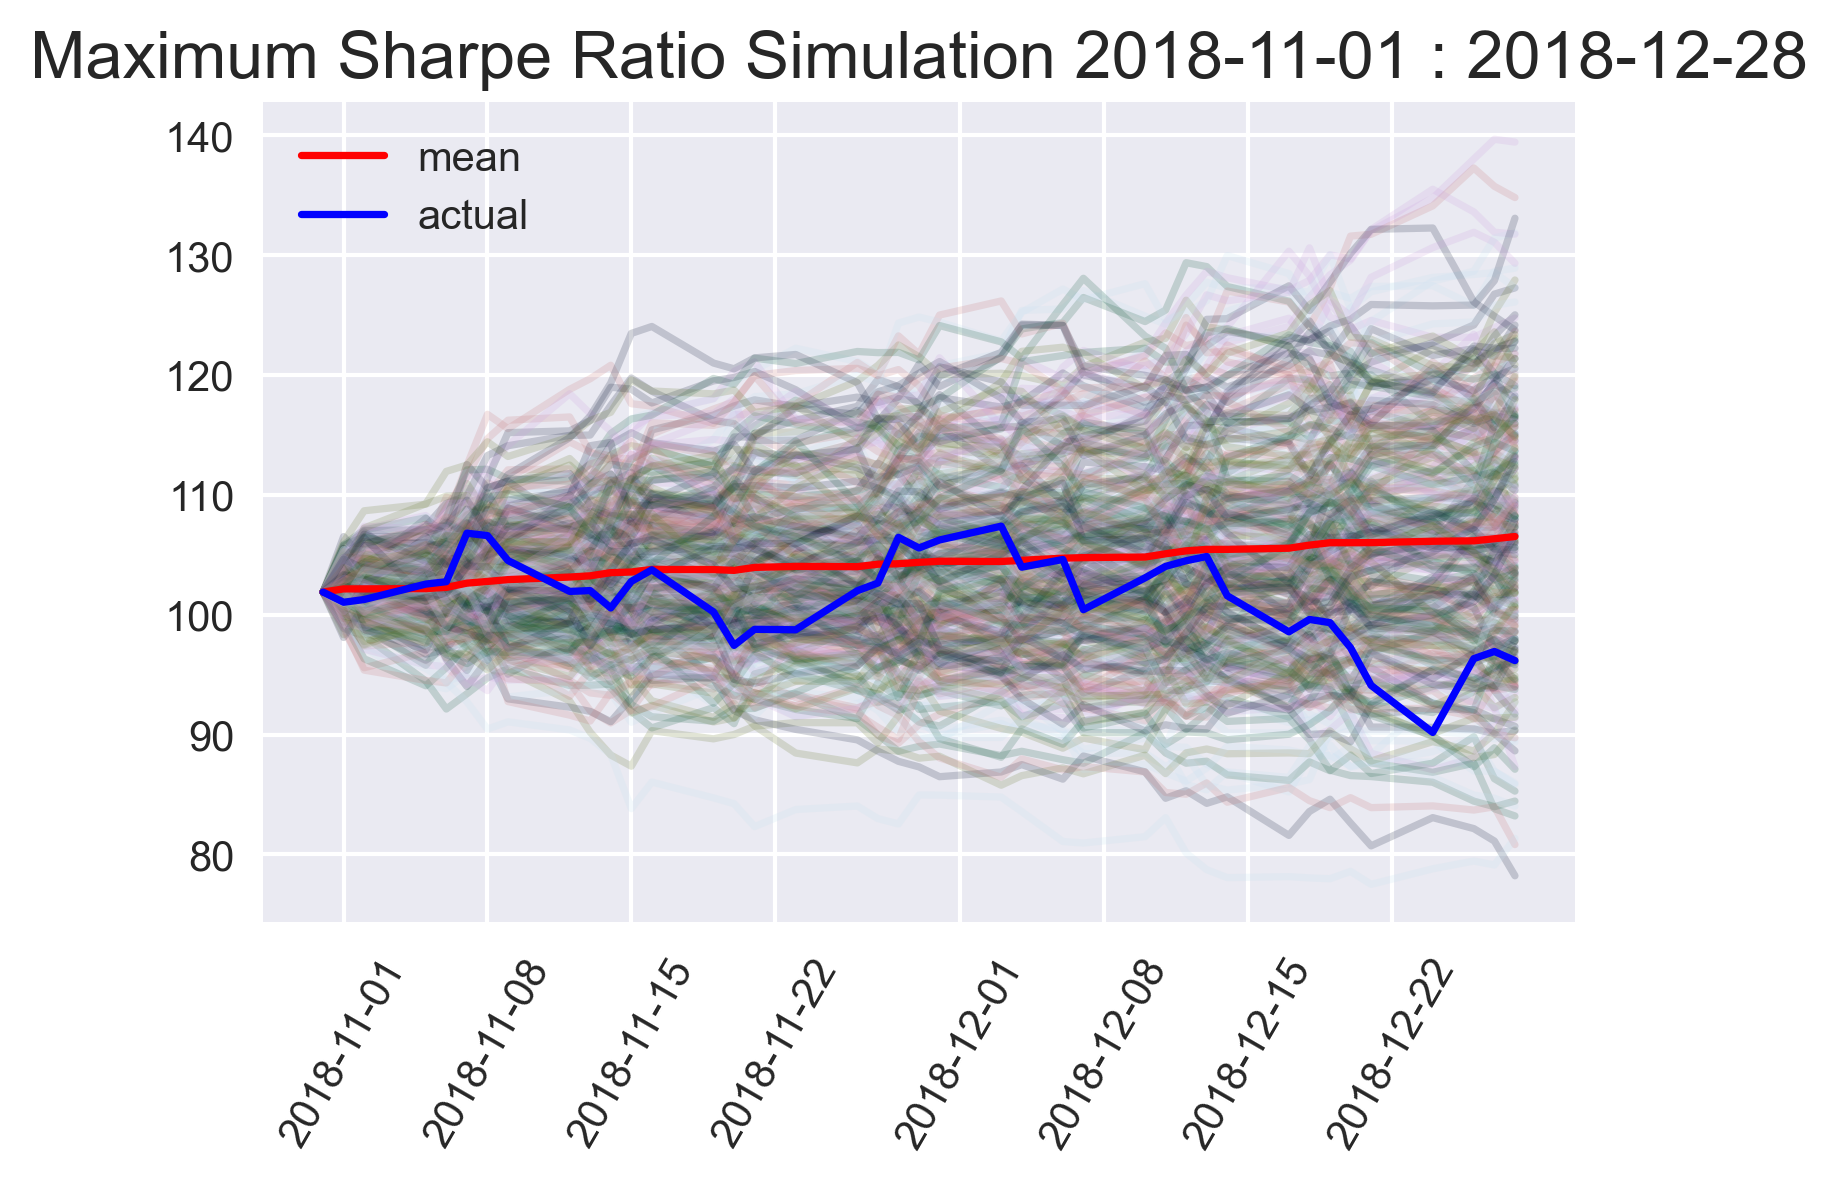

In [35]:
last_train_date = train.index[-1].date()
first_test_date = test.index[0].date()
last_test_date = test.index[-1].date()
plot_title = (f'Maximum Sharpe Ratio Simulation '
              f'{first_test_date} : {last_test_date}')

selected_indices = adj_close[last_train_date:last_test_date].index
index = [date.date() for date in selected_indices]

gbm_simulations_sharpe_df = pd.DataFrame(np.transpose(gbm_simulations_sharpe), 
                                  index=index)

ax = gbm_simulations_sharpe_df.plot(alpha=0.2, legend=False)
line_1, = ax.plot(index, gbm_simulations_sharpe_df.mean(axis=1), 
                  color='red')
line_2, = ax.plot(index, adj_close_sum_sharpe[last_train_date:last_test_date], 
                  color='blue')
ax.set_title(plot_title, fontsize=16)
ax.legend((line_1, line_2), ('mean', 'actual'))

plt.tight_layout()
plt.xticks(rotation=60)
plt.show()

## Monte-Carlo Simulation of Minimum Volatility Portfolio

In [36]:
adj_close_vol = adj_close.apply(lambda x: x * efficient_portfolios[min_vol_ind]['x'], axis=1)

In [37]:
returns_vol_portfolio = pd.Series(np.dot(efficient_portfolios[min_vol_ind]['x'], returns.T), index=returns.index)

In [38]:
train = returns_vol_portfolio['2018-01-01':'2018-10-31']
test = returns_vol_portfolio['2018-11-01':'2018-12-31']
adj_close_sum_vol = adj_close_vol.sum(axis=1)
adj_close_sum_vol_train = adj_close_sum_vol[:'2018-10-31']

In [39]:
T = len(test)
N = len(test) 
s_0 = adj_close_sum_vol_train[-1]
N_SIM = 300 
mu = train.mean()
sigma = train.std()

In [40]:
gbm_simulations_vol = simulate_gbm(s_0, mu, sigma, N_SIM, T, N)

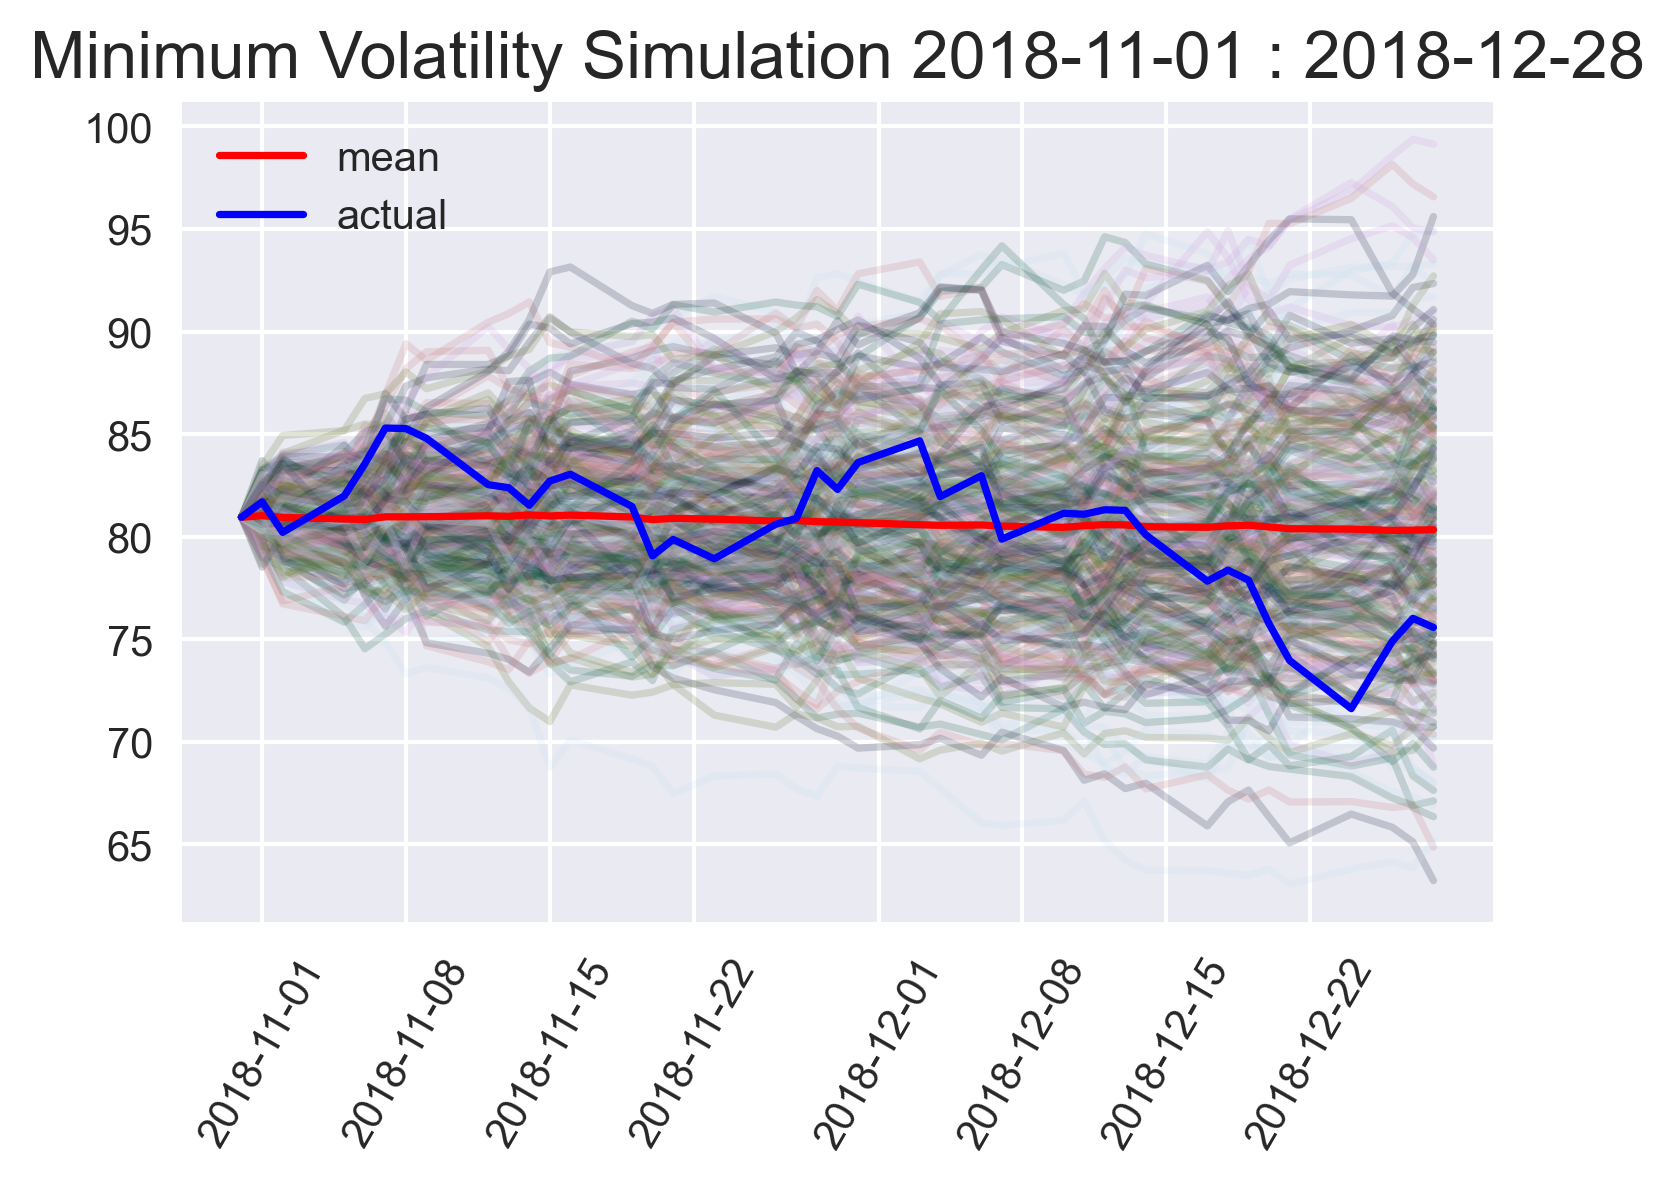

In [41]:
last_train_date = train.index[-1].date()
first_test_date = test.index[0].date()
last_test_date = test.index[-1].date()
plot_title = (f'Minimum Volatility Simulation '
              f'{first_test_date} : {last_test_date}')

selected_indices = adj_close[last_train_date:last_test_date].index
index = [date.date() for date in selected_indices]

gbm_simulations_vol_df = pd.DataFrame(np.transpose(gbm_simulations_vol), 
                                  index=index)

ax = gbm_simulations_vol_df.plot(alpha=0.2, legend=False)
line_1, = ax.plot(index, gbm_simulations_vol_df.mean(axis=1), 
                  color='red')
line_2, = ax.plot(index, adj_close_sum_vol[last_train_date:last_test_date], 
                  color='blue')
ax.set_title(plot_title, fontsize=16)
ax.legend((line_1, line_2), ('mean', 'actual'))

plt.tight_layout()
plt.xticks(rotation=60)
plt.show()